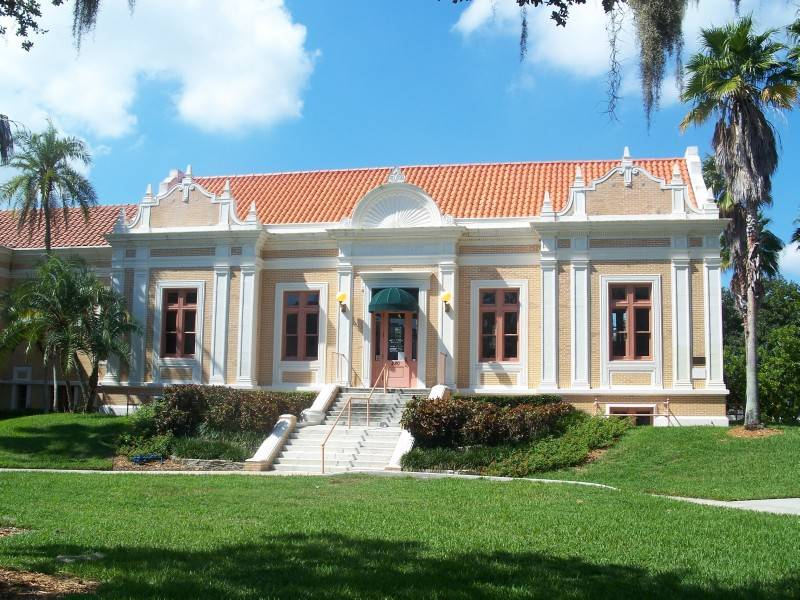

In [1]:
from IPython.display import Image
Image(filename='../input/landmark-retrieval-2020/train/0/0/0/000014b1f770f640.jpg') 



The purpose of this notebook is to illustrate how to create Resnet50 from scratch on Tensorflow 2.x . This kernel just uses top 100 classes. For actual competition we would need to model all classes with neccessary methods to handle class imbalance

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import tensorflow as tf
import cv2
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D,Concatenate, ReLU, LeakyReLU,Reshape, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
from tqdm import tqdm
import imgaug as ia
from imgaug import augmenters as iaa
from PIL import Image
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using TensorFlow backend.


**Path retrieval**


Taken from the public kernel...thanks for sharing this. It was quite helpful for me. Please upvote that kernel if you also found that helpful
https://www.kaggle.com/derinformatiker/landmark-retrieval-all-paths

In [3]:
train = pd.read_csv("../input/landmark-retrieval-2020/train.csv")
def get_paths(sub):
    index = ["0","1","2","3","4","5","6","7","8","9","a","b","c","d","e","f"]

    paths = []

    for a in index:
        for b in index:
            for c in index:
                try:
                    paths.extend([f"../input/landmark-retrieval-2020/{sub}/{a}/{b}/{c}/" + x for x in os.listdir(f"../input/landmark-retrieval-2020/{sub}/{a}/{b}/{c}")])
                except:
                    pass

    return paths

Thanks and Credits - @nawidsayed for suggesting a change in line number 3 and making it much more efficient. His profile link is given below:   https://www.kaggle.com/nawidsayed

In [4]:

train_path = train
train_path["id"] = train_path.id.map(lambda path: f"../input/landmark-retrieval-2020/train/{path[0]}/{path[1]}/{path[2]}/{path}.jpg")

In [5]:
##Old implementation - changed after suggestion from @nawidsayed
'''
train_path = train

rows = []
for i in tqdm(range(len(train))):
    row = train.iloc[i]
    path  = list(row["id"])[:3]
    temp = row["id"]
    row["id"] = f"../input/landmark-retrieval-2020/train/{path[0]}/{path[1]}/{path[2]}/{temp}.jpg"
    rows.append(row["id"])
    
rows = pd.DataFrame(rows)
train_path["id"] = rows
'''

'\ntrain_path = train\n\nrows = []\nfor i in tqdm(range(len(train))):\n    row = train.iloc[i]\n    path  = list(row["id"])[:3]\n    temp = row["id"]\n    row["id"] = f"../input/landmark-retrieval-2020/train/{path[0]}/{path[1]}/{path[2]}/{temp}.jpg"\n    rows.append(row["id"])\n    \nrows = pd.DataFrame(rows)\ntrain_path["id"] = rows\n'

**Setting up some basic model specs**

In [6]:
batch_size = 128
seed = 42
shape = (64, 64, 3) ##desired shape of the image for resizing purposes
val_sample = 0.1 # 10 % as validation sample


In [7]:
train_labels = pd.read_csv('../input/landmark-retrieval-2020/train.csv')
train_labels.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [8]:
k =train[['id','landmark_id']].groupby(['landmark_id']).agg({'id':'count'})
k.rename(columns={'id':'Count_class'}, inplace=True)
k.reset_index(level=(0), inplace=True)
freq_ct_df = pd.DataFrame(k)
freq_ct_df.head()

,landmark_id,Count_class
0,1,4
1,7,8
2,9,16
3,11,22
4,12,25


In [9]:
train_labels = pd.merge(train,freq_ct_df, on = ['landmark_id'], how='left')
train_labels.head()

,id,landmark_id,Count_class
0,../input/landmark-retrieval-2020/train/1/7/6/1...,1,4
1,../input/landmark-retrieval-2020/train/9/2/b/9...,1,4
2,../input/landmark-retrieval-2020/train/c/d/4/c...,1,4
3,../input/landmark-retrieval-2020/train/f/b/0/f...,1,4
4,../input/landmark-retrieval-2020/train/2/5/c/2...,7,8


In [10]:
freq_ct_df.sort_values(by=['Count_class'],ascending=False,inplace=True)
freq_ct_df.head()

,landmark_id,Count_class
55807,138982,6272
50843,126637,2231
8211,20409,1758
33462,83144,1741
45494,113209,1135


**Due to Kernel runtime limits, for illustrating the example let's run this for top 100 landmark categories**

In [11]:
freq_ct_df_top100 = freq_ct_df.iloc[:100]
top100_class = freq_ct_df_top100['landmark_id'].tolist()

In [12]:
top100class_train = train_path[train_path['landmark_id'].isin (top100_class) ]
top100class_train.shape

(66081, 2)

In [13]:
def getTrainParams():
    data = top100class_train.copy()
    le = preprocessing.LabelEncoder()
    data['label'] = le.fit_transform(data['landmark_id'])
    lbls = top100class_train['landmark_id'].tolist()
    lb = LabelBinarizer()
    labels = lb.fit_transform(lbls)
    
    return np.array(top100class_train['id'].tolist()),np.array(labels),le

Credit to Michal Haltuf from whose kernel I had first learnt Data Generators two years back.
You can check out his kernel here: https://www.kaggle.com/rejpalcz/cnn-128x128x4-keras-from-scratch-lb-0-328

In [14]:
class Landmark2020_DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, paths, labels, batch_size, shape, shuffle = False, use_cache = False, augment = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.augment = augment
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], shape[2]), dtype=np.float16)
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        # Generate data
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)

        y = self.labels[indexes]
                
        if self.augment == True:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5), # horizontal flips
                    
                    iaa.ContrastNormalization((0.75, 1.5)),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    
                    iaa.Affine(rotate=0),
                    #iaa.Affine(rotate=90),
                    #iaa.Affine(rotate=180),
                    #iaa.Affine(rotate=270),
                    iaa.Fliplr(0.5),
                    #iaa.Flipud(0.5),
                ])], random_order=True)

            X = np.concatenate((X, seq.augment_images(X), seq.augment_images(X), seq.augment_images(X)), 0)
            y = np.concatenate((y, y, y, y), 0)
        
        return X, y
    
    def on_epoch_end(self):
        
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image_norm = skimage.io.imread(path)/255.0
        

        im = resize(image_norm, (shape[0], shape[1],shape[2]), mode='reflect')
        return im

In [15]:
nlabls = top100class_train['landmark_id'].nunique()

**Let's build the building blocks of a Resnet model one by one**



Credits: Prof. Andrew Ng course on deep learning

**The complete architecture of a ResNet50 can be shown as follows:**

![](https://miro.medium.com/max/2792/1*hEU7S-EiVqcmtAlj6kgfRA.png)

Starting first with the identity block creation

![](https://i.stack.imgur.com/37qzA.png)

In [16]:
def identity_block(X, f, filters, stage, block):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
        
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
        
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Add shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
        
    return X

Creating the convolutional block

![](https://i.stack.imgur.com/0mE2p.png)

In [17]:
def convolutional_block(X, f, filters, stage, block, s = 2):
        
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
   
    return X

**Bringing everything together**

The architecture we are trying to implement is as follows:

CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    
    
The detailed architecture of ResNet-50 model is:

* Zero-padding pads the input with a pad of (3,3)
* Stage 1:
        The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). Its name is "conv1".
        BatchNorm is applied to the channels axis of the input.
        MaxPooling uses a (3,3) window and a (2,2) stride.
* Stage 2:
        The convolutional block uses three set of filters of size [64,64,256], "f" is 3, "s" is 1 and the  block is "a".
        The 2 identity blocks use three set of filters of size [64,64,256], "f" is 3 and the blocks are "b" and "c".
    Stage 3:
        The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
        The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
    Stage 4:
        The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
        The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
    Stage 5:
        The convolutional block uses three set of filters of size [512, 512, 2048], "f" is 3, "s" is 2 and the block is "a".
        The 2 identity blocks use three set of filters of size [512, 512, 2048], "f" is 3 and the blocks are "b" and "c".
*     The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
*     The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. 

In [18]:
def ResNet50(input_shape = (64, 64, 3), classes = nlabls):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    X = AveragePooling2D(pool_size=(2, 2),name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    return model

In [19]:
from tensorflow.keras.metrics import categorical_accuracy,top_k_categorical_accuracy
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [20]:
model = ResNet50(input_shape = (64, 64, 3), classes = nlabls)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',top_5_accuracy])
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [21]:
paths, labels,_ = getTrainParams()

In [22]:
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(seed)
np.random.shuffle(keys)
lastTrainIndex = int((1-val_sample) * paths.shape[0])

pathsTrain = paths[0:lastTrainIndex]
labelsTrain = labels[0:lastTrainIndex]

pathsVal = paths[lastTrainIndex:]
labelsVal = labels[lastTrainIndex:]

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)

(66081,) (66081, 100)
(59472,) (59472, 100) (6609,) (6609, 100)


In [23]:
train_generator = Landmark2020_DataGenerator(pathsTrain, labelsTrain, batch_size, shape, use_cache=False, augment = False, shuffle = True)
val_generator = Landmark2020_DataGenerator(pathsVal, labelsVal, batch_size, shape, use_cache=False, shuffle = False)

In [24]:
epochs = 2
use_multiprocessing = True 
#workers = 1 

In [25]:
base_cnn = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=64,
    #class_weight = class_weights,
    epochs=epochs,
    #callbacks = [clr],
    use_multiprocessing=use_multiprocessing,
    #workers=workers,
    verbose=1)

Epoch 1/2
465/465 [==============================] - 5931s 13s/step - loss: 3.0558 - acc: 0.2975 - top_5_accuracy: 0.5095 - val_loss: 13.5168 - val_acc: 4.9110e-04 - val_top_5_accuracy: 0.0192
Epoch 2/2
465/465 [==============================] - 6279s 14s/step - loss: 2.1293 - acc: 0.4653 - top_5_accuracy: 0.7153 - val_loss: 14.6706 - val_acc: 2.4555e-04 - val_top_5_accuracy: 0.0068


In [26]:
model.save('ResNet50.h5')

**If you found this useful, an upvote would be much appreciated.**

**Image Credits:**

[Stackoverflow](https://stackoverflow.com/questions/58200107/stuck-understanding-resnets-identity-block-and-convolutional-blocks)


[Medium](https://miro.medium.com/max/2792/1*hEU7S-EiVqcmtAlj6kgfRA.png)